In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S"))

Summary run: Tue, 11 Jun 2024 11:02:28


In [3]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [4]:
pd.options.display.float_format = '{:0,.0f}'.format

In [5]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [6]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

purp_dict = {
    0: 'Home',
    1: 'Work',
    2: 'School',
    3: 'Escort',
    4: 'Personal Business',
    5: 'Shopping',
    6: 'Meal',
    7: 'Social',
    8: 'Recreational',
    9: 'Medical',
    10: 'Change Mode'
}

mode_dict = {
    1: 'Walk',
    2: 'Bike',
    3: 'SOV',
    4: 'HOV2',
    5: 'HOV3+',
    6: 'Transit',
    8: 'School Bus'
}

In [7]:
# Load Network Summary sheet from network_summary_detailed
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VMT by FC')

## Vehicle Miles Traveled (VMT)

In [8]:
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VMT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VMT']]

# Save total VMT for later use
total_vmt = df_tod.loc['Total'].values[0]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VMT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

df_fac.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','1_vmt_facility_type.csv'))
df_tod.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','2_vmt_tod.csv'))
display(df_fac)
display(df_tod)

,VMT
Facility Type,
arterial,"36,401,492"
highway,"43,122,928"
connector,"5,206,862"
Total,"84,731,282"


,VMT
period,
am,"19,098,765"
ev,"10,663,081"
md,"29,344,585"
ni,"5,754,890"
pm,"19,869,962"
Total,"84,731,282"


## Vehicle Hours Traveled (VHT)

In [9]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','VHT by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['VHT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VHT']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway','connector']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VHT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

df_fac.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','3_vht_facility_type.csv'))
df_tod.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','4_vht_tod.csv'))

display(df_fac)
display(df_tod)

,VHT
Facility Type,
arterial,"1,240,355"
highway,"1,019,888"
connector,"332,679"
Total,"2,592,922"


,VHT
period,
am,"587,976"
ev,"346,438"
md,"855,094"
ni,"148,084"
pm,"655,331"
Total,"2,592,922"


## Delay

In [10]:
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary.xlsx','delay by FC')
df_tod = df.groupby(['period']).sum()[['arterial','connector','highway']]
df_tod['Delay'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['Delay']]

df_fac = pd.DataFrame(df.sum()[['arterial','highway']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'Delay']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

df_fac.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','5_delay_facility_type.csv'))
df_tod.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','6_delay_tod.csv'))

display(df_fac)
display(df_tod)

,Delay
Facility Type,
arterial,"114,754"
highway,"206,399"
Total,"321,152"


,Delay
period,
am,"94,453"
ev,"46,037"
md,"63,613"
ni,0
pm,"117,050"
Total,"321,152"


## VMT per Person

In [11]:
# Load Daysim results
trip = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_trip.tsv', sep='\t')
person = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_person.tsv', sep='\t')

In [12]:
# Load survey results
survey_trip = pd.read_csv(os.path.join(survey_path,'_trip.tsv'), delim_whitespace=True)
survey_person = pd.read_csv(os.path.join(survey_path,'_person.tsv'), delim_whitespace=True)

In [13]:
pd.options.display.float_format = '{:0,.2f}'.format


# This is average trips
model_value = trip['trexpfac'].sum()/person['psexpfac'].sum()
survey_value = survey_trip['trexpfac'].sum()/survey_person['psexpfac'].sum()

_df = pd.DataFrame([total_vmt/person['psexpfac'].sum()])

_df.columns = ['Average VMT per Capita']
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','7_vmt_per_person.csv'))
_df


,Average VMT per Capita
0,19.45


## Trips per Person

In [14]:
model_result = (trip['trexpfac'].sum()*1.0)/person['psexpfac'].sum()
survey_result = (survey_trip['trexpfac'].sum()*1.0)/survey_person['psexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Total Trips per Capita']
_df.index = ['Model', 'Survey']
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','8_trips_per_person.csv'))
_df

,Total Trips per Capita
Model,3.70
Survey,3.61


## Trip Distance by Purpose

In [15]:
trip['wt_dist'] = trip['trexpfac']*trip['travdist']
_df = pd.DataFrame(trip.groupby('dpurp').sum()['wt_dist']/trip.groupby('dpurp').sum()['trexpfac']).reset_index()

survey_trip['wt_dist'] = survey_trip['trexpfac']*survey_trip['travdist']
_df_survey = pd.DataFrame(survey_trip.groupby('dpurp').sum()['wt_dist']/survey_trip.groupby('dpurp').sum()['trexpfac']).reset_index()
_df = _df.merge(_df_survey, on='dpurp', suffixes=['_model', '_survey'])
_df.rename(columns={'0_model': 'Model', '0_survey': 'Survey', 'dpurp': 'Trip Purpose'}, inplace=True)
_df['Trip Purpose'] = _df['Trip Purpose'].map(purp_dict)

# Add a row for totals
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()
_df.loc[len(_df)] = ['All Trips',model_result, survey_result]
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','9_trip_distance_purpose.csv'))
_df

,Trip Purpose,Model,Survey
0,Home,5.76,6.07
1,Work,8.66,8.63
2,School,3.56,3.78
3,Escort,5.74,5.34
4,Personal Business,4.98,5.33
5,Shopping,4.05,4.01
6,Meal,4.87,3.88
7,Social,4.32,5.89
8,All Trips,5.55,5.83


## Trip Distance by Mode

In [16]:
trip['wt_dist'] = trip['trexpfac']*trip['travdist']
_df = pd.DataFrame(trip.groupby('mode').sum()['wt_dist']/trip.groupby('mode').sum()['trexpfac']).reset_index()

survey_trip['wt_dist'] = survey_trip['trexpfac']*survey_trip['travdist']
_df_survey = pd.DataFrame(survey_trip.groupby('mode').sum()['wt_dist']/survey_trip.groupby('mode').sum()['trexpfac']).reset_index()
_df = _df.merge(_df_survey, on='mode', suffixes=['_model', '_survey'])
_df.rename(columns={'0_model': 'Model', '0_survey': 'Survey', 'mode': 'Trip Mode'}, inplace=True)
_df['Trip Mode'] = _df['Trip Mode'].map(mode_dict)

# Add a row for totals
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()
_df.loc[len(_df)] = ['All Trips',model_result, survey_result]
_df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','10_trip_distance_mode.csv'))
_df

,Trip Mode,Model,Survey
0,Walk,0.98,0.88
1,Bike,3.61,2.20
2,SOV,6.99,6.89
3,HOV2,5.68,5.23
4,HOV3+,5.82,6.30
5,Transit,8.59,10.07
6,School Bus,3.02,2.77
7,NaN,2.17,5.93
8,All Trips,5.55,5.83


## Transit Boardings

In [17]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','11_transit_boardings.csv'))
df

,boardings
agency_name,
King County Metro,"358,808.62"
Sound Transit,"150,225.35"
Community Transit,"27,175.61"
Kitsap Transit,"27,157.31"
Pierce Transit,"21,826.44"
Washington Ferries,"5,233.50"
Everett Transit,"3,122.08"
Region Total,"593,548.92"


## Trip Mode Share

,Model,Survey
mode,,
Walk,13.5%,9.9%
Bike,1.1%,0.7%
SOV,39.5%,44.2%
HOV2,21.6%,18.6%
HOV3+,18.8%,21.5%
Transit,2.5%,2.5%
School Bus,2.0%,1.9%
TNC,1.0%,0.2%


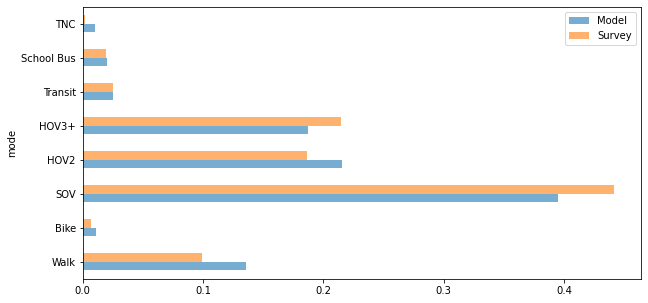

In [18]:
pd.options.display.float_format = '{:,.1%}'.format
model_df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
model_df = model_df.reset_index()
survey_df = survey_trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/survey_trip[['trexpfac']].sum()
survey_df = survey_df.reset_index()
_df = pd.merge(model_df, survey_df, on='mode', how='left')
_df.columns = ['mode','Model', 'Survey']
# _df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
# _df = _df.reset_index()
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
_df.replace({'mode':mode_dict}, inplace=True)
_df.index = _df['mode']
_df.drop('mode', axis=1, inplace=True)
dfplot = _df.drop('Other', axis=0)
dfplot.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','12_trip_mode_share.csv'))
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)


# Home-Based Work Trip Mode Share

In [19]:
trip['Trip Type'] = 'Not Home-Based Work'
trip.loc[(((trip['opurp']==0) & (trip['dpurp']==1)) | ((trip['opurp']==1) & (trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
hbw_trips = trip.loc[trip['Trip Type']=='Home-Based Work']
model_df_hbw = hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/hbw_trips[['trexpfac']].sum()
model_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_hbw.replace({'mode':mode_dict}, inplace=True)
model_df_hbw.columns = ['mode', 'share']
model_df_hbw

# Survey trip
survey_trip.loc[(((survey_trip['opurp']==0) & (survey_trip['dpurp']==1)) | ((survey_trip['opurp']==1) & (survey_trip['dpurp']==0))),'Trip Type']= 'Home-Based Work'
survey_hbw_trips = survey_trip.loc[survey_trip['Trip Type']=='Home-Based Work']
survey_df_hbw = survey_hbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_hbw_trips[['trexpfac']].sum()
survey_df_hbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_hbw.replace({'mode':mode_dict}, inplace=True)
survey_df_hbw.columns = ['mode', 'share']

model_df_hbw.merge(survey_df_hbw, on='mode', suffixes=['_model','_survey']).reset_index()
model_df_hbw.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','13_hbw_trip_mode_share.csv'))
model_df_hbw

,mode,share
0,Walk,6.0%
1,Bike,1.4%
2,SOV,71.9%
3,HOV2,9.2%
4,HOV3+,5.9%
5,Transit,5.3%
6,School Bus,0.0%
7,TNC,0.3%


# Other Trip Mode Share (Not Home-Based Work)

In [20]:
nhbw_trips = trip.loc[trip['Trip Type']!='Home-Based Work']
model_df_nhbw = nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/nhbw_trips[['trexpfac']].sum()
model_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
model_df_nhbw.replace({'mode':mode_dict}, inplace=True)
model_df_nhbw.columns = ['mode', 'share']


# Survey trip
survey_nhbw_trips = survey_trip.loc[trip['Trip Type']!='Home-Based Work']
survey_df_nhbw = survey_nhbw_trips[['mode','trexpfac']].groupby(['mode']).sum()[['trexpfac']]/survey_nhbw_trips[['trexpfac']].sum()
survey_df_nhbw.reset_index(inplace=True)
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus',9:'TNC'}
survey_df_nhbw.replace({'mode':mode_dict}, inplace=True)
survey_df_nhbw.columns = ['mode', 'share']


survey_df_nhbw.merge(model_df_nhbw, on='mode', suffixes=['_model','_survey']).reset_index()
survey_df_nhbw.to_csv(os.path.join(os.getcwd(), r'..\..\..\outputs\compare\topsheet','14_other_trip_mode_share.csv'))
survey_df_nhbw

,mode,share
0,Walk,10.1%
1,Bike,0.7%
2,SOV,44.9%
3,HOV2,18.4%
4,HOV3+,20.7%
5,Transit,2.4%
6,School Bus,2.1%
7,TNC,0.2%
8,10,0.5%
